## Scientific Computing 2021: Homework Assignment 1 
Due Monday October 11, 2021, 23:59

### Problem 1 (2 points)
Under assumptions of Amdahl's law, suppose that 75% of a program are perfectly parallelizable, and the rest is not parallelizable. 
1. What is the maximum speedup achievable by parallelization? 
2. Suppose that we have obtained speedup 2 (by using a suitable number of processes). What is the efficiency of this parallelization? 

1.
$$ 
\text{Speedup} = \frac{1}{S + \frac{1}{N}(1 - S)} = \vert S = 1 - 0.75 = 0.25 \vert = \frac{1}{0.25 + \frac{1}{N}(1 - 0.25)} = \frac{1}{0.25 + \frac{0.75}{N}} = \frac{4}{1 + \frac{3}{N}} \\
\text{Speedup} \rightarrow \max \iff \frac{3}{N} \rightarrow 0 \\
\Rightarrow \text{Speedup}_{max} = 4
$$

2.
$$
\text{Speedup} = \frac{T(1)}{T(N)} = 2 \\
\text{Efficiency} = \frac{T(1)}{N \cdot T(N)} = \frac{\text{Speedup}}{N} = \frac{2}{N}
$$

### Problem 2 (2 points)
Write a Python or C/C++ program that uses **MPI reduce** to find the largest file in terms of the  number of lines among all .txt files in the working directory (only .txt files should be examined). The program must be callable in the form `mpirun -np <N> python linecount.py` (in the case of the Python version) or `mpirun -np <N> linecount.exe` (the C/C++ version), where `<N>` is the user-defined number of processes. The program is expected to first somehow distribute the files found in the current directory to the processes, then each process should count the lines in the files assigned to it, and finally the result should be MPI-reduced and printed out. The program only needs to output the number of lines in the largest file; no need to output the name of this file. The program must work correctly even if the number of files is not divisible by the number of processes.


In [ ]:
from mpi4py import MPI
from os import listdir
from os.path import isfile, join

my_path = 'C:\\Users\\ghost\\Desktop\\test'

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

files_list = [f for f in listdir(my_path) \
              if isfile(join(my_path, f)) \
              and f.endswith('.txt')]

id = rank - 1 if size > 1 else 0
local_max = 0

while 0 <= id < len(files_list):
    file_name = f'{my_path}\\{files_list[id]}'

    num_lines = sum(1 for line in open(file_name))

    local_max = max(num_lines, local_max)
    id += size

global_max = comm.reduce(local_max, op=MPI.MAX, root=0)

if rank == 0:
    print(f'The biggest text file has {global_max} lines')

In [ ]:
!mpiexec -np 2 python mpi.py 

### Problem 3 (2 points)
Solve the Distinct Substrings problem at Sphere online judge: http://www.spoj.com/problems/DISUBSTR/. Provide code passing the test of the judge. Explain how your code works and theoretically estimate the complexity of the algorithm (as $O(f(N))$, where $f(N)$ is some function of the length of the input string). 


#### Python approach

In [6]:
import numpy as np

In [7]:
def invPerm(p):
    '''Invert the permutation p'''
    s = np.empty(p.size, p.dtype)
    s[p] = np.arange(p.size)
    return s

In [8]:
def getSA(A):
    if not type(A) is np.ndarray:
        A = np.array(list(A))
    N = len(A) 
    M = int(np.ceil(np.log2(N))) + 1   # number of iterations
    
    # auxiliary arrays; row m stores results after m'th step:
    
    # positions of sorted length-(2**m) sequences in A
    P = np.zeros((M,N), dtype=int) 
    
    # rank (0, 1, etc.) of sorted length-(2**m) sequences after sorting
    Q = np.zeros((M,N), dtype=int)     
    
    # rank of sorted length-(2**m) sequences at its starting position in A;
    # padded by 0 on the right
    R = np.zeros((M,3*N), dtype=int) 

    for k in range(M):
        if k == 0:
            P[0] = np.argsort(A)
            Q[0][1:] = np.cumsum(A[P[0]][1:] != A[P[0]][:-1])
            R[0][:N] = Q[0][invPerm(P[0])]
        else:
            offset = 2**(k-1)
            r = np.lexsort((R[k-1, P[k-1]+offset], R[k-1, P[k-1]]))
            P[k] = P[k-1][r]
            # k'th rank increases iff (k-1)'th rank increases at least for one element of the pair    
            Q[k][1:] = np.cumsum(np.logical_or(R[k-1][P[k]][1:] != R[k-1][P[k]][:-1], 
                                          R[k-1][P[k]+offset][1:] != R[k-1][P[k]+offset][:-1]))
            R[k][:N] = Q[k][invPerm(P[k])]
            
            # early stopping if suffixes already fully sorted (max rank is N-1)
            if Q[k][-1] == N-1: 
                break
    
    SA = P[k]
    return SA, P[:k+1], Q[:k+1], R[:k+1]        

In [9]:
def getLCP(SA, R):
    (M, N) = R.shape
    LCP = np.zeros((len(SA)-1,),dtype=int)
    for m in range(M-1)[::-1]:
        t = (R[m][SA[1:]+LCP] == R[m][SA[:-1]+LCP]).astype(int)
        LCP += (2**m)*t
    return LCP

In [12]:
size = int(input())
for _ in range(size):
    A = input() + '$'
    SA, _, _, R = getSA(A)
    LCP = getLCP(SA, R)

    arythm_sum = (1 + len(A) - 1) / 2 * (len(A) - 1)

    print(int(arythm_sum - sum(LCP)))

2
CCCCC
15.0 10
Unique substrings num:  5


#### C++ Approach

In [ ]:
#include <iostream>
#include <string>
#include <vector>
#include <algorithm>

using namespace std;

size_t get_ans(const string &line);

int main() {
    ios_base::sync_with_stdio(false);
    cin.tie(nullptr);
    cout.tie(nullptr);
    size_t cnt;
    cin >> cnt;
    for (size_t i = 0; i < cnt; ++i) {
        string line;
        cin >> line;
        cout << get_ans(line) << endl;
    }
    return 0;
}

vector<int> get_prefix_func(const string &line) {
    vector<int> pi(line.size(), 0);
    for (size_t i = 1; i < pi.size(); ++i) {
        auto k = pi[i - 1];
        while (k > 0 && line[i] != line[k]) {
            k = pi[k - 1];
        }
        if (line[i] == line[k]) {
            pi[i] = k + 1;
        }
    }
    return pi;
}

size_t get_ans(const string &line) {
    size_t counter = 0;
    string temp = string("");
    for (const auto &c: line) {
        temp += c;
        auto rev_temp = temp;
        reverse(rev_temp.begin(), rev_temp.end());
        auto pi = get_prefix_func(rev_temp);
        counter += temp.size() - *max_element(pi.begin(), pi.end());
        cout << temp << endl;
    }
    return counter;
}

### Problem 4 (2 points)
Suppose that we want to distribute $N$ personal projects to $N$ students. Assume that each student $(k)_{k=0}^{N-1}$ has a list of his/her preferences for the projects, expressed as a vector $\mathbf r_k$ of integer ranks assigned to each project. Ranks vary between 0 and $N-1$ without repetitions, the **lower** the rank the **more preferable** the project. (For example, the first student's ranks are $\mathbf r_0 = [2,1,0]$, the second's $\mathbf r_1 = [0,2,1]$ and the third $\mathbf r_2 = [0,1,2]$). We want to distribute the projects so as to maximize the total preference, i.e., if $n_k$ denotes the project assigned to the $k$'th student, we want to make $f = \sum_{k=0}^{N-1} \mathbf r_k[n_k]$ as small as possible. (In the example above the optimal distribution is $n_0=2, n_1=0, n_2=1$, which gives $f=1$).  
  * Come up with an algorithm optimizing the distribution and implement it in a Python or C/C++ program. The algorithm should accept the preference vectors and output a recommended distribution $(n_k)_{k=1}^N$. The algorithm need not find the best solution, but is expected to generally produce better solutions than would have been obtained by randomly distributing the projects. The algorithm should be reasonably fast, say run in not more than a few seconds for $N=30$. 
  * Compare experimentally your algorithm with the trivial algorithm producing a random distribution. To this end, perform $M=1000$ experiments in each of which 1) random preference vectors for $N=30$ students and projects are generated; 2) the objective function $f$ is evaluated for both algorithms. After finishing all the experiments, plot the two respective distributions of the obtained $M$ values of $f$ and compute the mean values of $f$ for both algorithms. 

In [3]:
def get_algo_dstr(students, N):    
    students_copy = dict(students)

    pty_to_project = dict([(x, []) for x in range(N)])
    proj_dstr = dict([(x, None) for x in range(N)])
    
    for stud in students:
        for id, pty in enumerate(students[stud]):
            pty_to_project[pty].append(id)

    for pty_id in pty_to_project.keys():

        for s_id, pos in enumerate(pty_to_project[pty_id]):
            proj_id = pty_to_project[pty_id][s_id]

            if proj_dstr[proj_id] is None and s_id in students.keys():
                proj_dstr[proj_id] = s_id
                del students[s_id]

    rev_dict = dict([(x, None) for x in range(N)])

    for k, v in proj_dstr.items():
        rev_dict[v] = k

    return rev_dict

In [4]:
def get_f(students, proj_dstr):
    f = 0

    for s, p in zip(students, proj_dstr.values()): 
        f += students[s][p] * p
        
    return f

In [5]:
import numpy as np

In [6]:
N = 30
M = 1000

rand_list = []
algo_list = []

for _ in range(100): 
    input = dict([(x, None) for x in range(N)])
    
    for i in input.keys():
        input[i] = np.random.permutation(N)

    rand_dstr = dict([(x, None) for x in range(N)])
    for id, val in zip(rand_dstr.keys(), np.random.permutation(N)):
        rand_dstr[id] = val

    algo_dstr = get_algo_dstr(dict(input), N)    

    algo_list.append(get_f(input, algo_dstr))
    rand_list.append(get_f(input, rand_dstr))


print('algo: {}\nrandom: {}'.format(np.mean(algo_list), np.mean(rand_list)))
# print(algo_list, rand_list, sep='\n')

algo: 828.58
random: 6416.55


In [7]:
import matplotlib.pyplot as plt

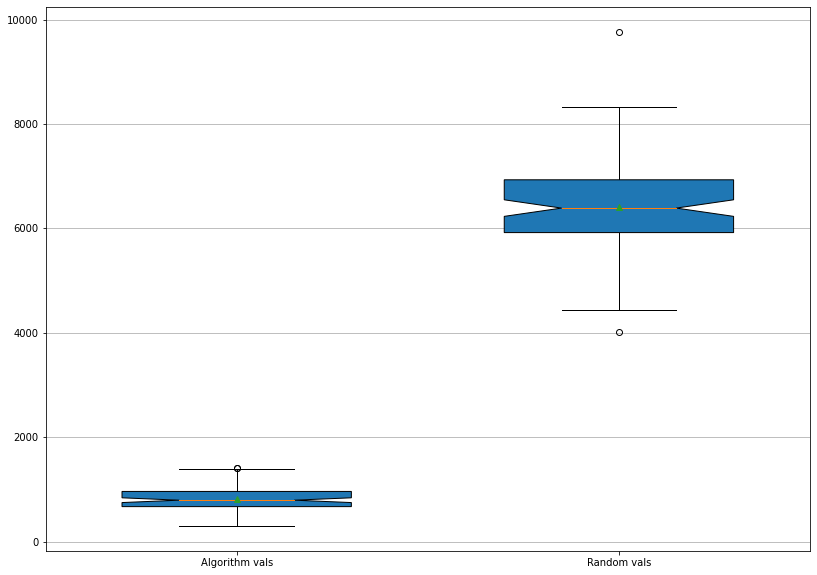

In [8]:
plot_dict = {"Algorithm vals": algo_list, "Random vals": rand_list}

fig, ax = plt.subplots(figsize=(13.7, 10))

fig.figsize = (13.7, 10)

bplot = ax.boxplot(plot_dict.values(), showmeans=True, widths = 0.6, notch=True, patch_artist=True)
ax.set_xticklabels(plot_dict.keys())
ax.yaxis.grid(True)

### Problem 5 (2 points)
Suppose that we have developed an algorithm that is supposed to generate independent (quasi-)random numbers uniformly distributed in the interval $[0,1]$. To test our algorithm, we perform a series of experiments. In each experiment, we generate $N=10^3$ numbers $(x_n)_{n=1}^N$ with our algorithm, and compute the minimum distance $r=\min_{1 \le n < m\le N}|x_n-x_m|$ between them. We observe that in more than 99% of such experiments we obtain $r < 10^{-5}$. Does this observation contradict the hypothesis of generating independent uniformly distributed random numbers? Explain your answer.